In [80]:
'''
Written by rizawa
Written on 2018-06-08
'''

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import psycopg2
import json
import os
import re
from datetime import date
from datetime import datetime

with open('/Users/rizawa/Code/config/settings.json') as config_file:
    config = json.load(config_file)


CONNECTION_PARAMETERS = config['dbs']

HOST = CONNECTION_PARAMETERS['hostname']
USER = CONNECTION_PARAMETERS['username']
WORD = CONNECTION_PARAMETERS['password']
DTBS = CONNECTION_PARAMETERS['database']
PORT = CONNECTION_PARAMETERS['port']


def execute_query(query):
    connection = psycopg2.connect(host=HOST,user=USER,password=WORD,dbname=DTBS,port=PORT)
    cur = connection.cursor()
    cur.execute(query)
    column_list = [c[0] for c in cur.description]
    df_query = pd.DataFrame(cur.fetchall(), columns=column_list)
    connection.close()
    return df_query

In [81]:
lucy = 41
meg = 43
blaine = 140535
steph = 359269
sal = 470987
jonathan = 717168
cecilia = 798523
caroline = 800584
allegra = 1309173
rivka = 7229774
tamichurns = 8137719
lauren = 8850836
kyra = 11020280
tatum = 29511006
tiffany = 29629049
ryu = 30661306
hyoju = 33668462
spencer = 38231503
tami = 46453526
kaspar = 49582469
norah = 93261038
ray = 103718336
pete = 114328697
hannah = 120756882

In [82]:
def query_edges(incl=0,excl=0):
    
    query_str = """
    select distinct
    events.account_id as a
    ,guests.account_id as b
    ,count(*) as bond
    from paperless_public.events
    join paperless_public.guests on events.id = guests.event_id 
    where events.account_id != guests.account_id
    and guests.sent_at is not null
    and events.account_id in (""" + str(incl) + """)
    and guests.account_id not in (""" + str(excl) + """)
    group by 1,2

    union

    select distinct
    guests.account_id as a
    ,events.account_id as b
    ,count(*) as bond
    from paperless_public.events
    join paperless_public.guests on events.id = guests.event_id 
    where events.account_id != guests.account_id
    and guests.sent_at is not null
    and guests.account_id in (""" + str(incl) + """)
    and events.account_id not in (""" + str(excl) + """)
    group by 1,2
    ;
    """
    return query_str

In [83]:
def find_path(edges_x, edges_y):

    common_nodes = set(edges_x['b']) & set(edges_y['b'])

    if not common_nodes:

        incl = ",".join(str(e) for e in edges_x['b'])
        excl = ",".join(str(e) for e in edges_x['a'])
        str_query = query_edges(incl,excl)
        edges_q = execute_query(str_query)
        
        incl = ",".join(str(e) for e in edges_y['b'])
        excl = ",".join(str(e) for e in edges_y['a'])
        str_query = query_edges(incl,excl)
        edges_r = execute_query(str_query)
        
        beam = find_path(edges_q, edges_r)
        # Merge and rename the columns so they can be merged later
        fore = pd.merge(edges_x[['a','b']], beam, on='b', how='inner')
        cols = ['a']
        for c in range(2,len(fore.columns)):
            cols.append(c)
        cols.append('b')
        fore.columns = cols
        # Merge and rename the columns so they can be merged later
        ship = pd.merge(fore, edges_y[['a','b']], on='b', how='inner')
        cols = ['a']
        for c in range(2,len(ship.columns)):
            cols.append(c)
        cols.append('b')
        ship.columns = cols
        
    else:
        
        ship = pd.merge(edges_x, edges_y, on='b', how='inner')[['a_x','b','a_y']]
        ship.columns = ['b','x','a']
    
    paths = ship
    return paths

In [84]:
start_time = datetime.now()

acct0 = ryu
acct1 = meg

str_query = query_edges(str(acct0))
edges_0 = execute_query(str_query)

str_query = query_edges(str(acct1))
edges_1 = execute_query(str_query)

paths = find_path(edges_0, edges_1)
# Renaming the columns for ease of use.
cols = []
for c in range(0,len(paths.columns)):
    cols.append(c)
paths.columns = cols

# Reducing the accounts to unique account_ids,
# then querying all edges involving these accounts.
unique_accounts = pd.unique(paths.values.ravel('K'))
str_acct = ",".join(str(e) for e in unique_accounts)
str_query = query_edges(str_acct)
all_edges = execute_query(str_query)

# Building the graph from the queried edges.
G = nx.from_pandas_edgelist(all_edges, 'a', 'b', ['bond'])

print('completed in: ' + str(datetime.now() - start_time))

completed in: 0:00:15.057764


In [85]:
start_time = datetime.now()

str_query = query_paths(str_acct)
path_edges = execute_query(str_query)

for path in nx.all_simple_paths(G, source=acct0, target=acct1, cutoff=4):
    print(path)

print('completed in: ' + str(datetime.now() - start_time))

[30661306, 87906522, 1413491, 25015, 43]
[30661306, 87906522, 25136661, 412067, 43]
[30661306, 87906522, 716117, 1310, 43]
[30661306, 87906522, 24410669, 68569, 43]
[30661306, 87906522, 75647, 146037, 43]
[30661306, 87906522, 38475543, 1491786, 43]
[30661306, 87906522, 856681, 722, 43]
[30661306, 4508897, 2849, 1751, 43]
[30661306, 4508897, 88362317, 88732, 43]
[30661306, 4508897, 88362317, 1491786, 43]
[30661306, 4508897, 19815372, 1818941, 43]
[30661306, 47377372, 2849, 1751, 43]
[30661306, 47377372, 89227, 25015, 43]
[30661306, 47377372, 89227, 850069, 43]
[30661306, 47377372, 89227, 57753, 43]
[30661306, 47377372, 89227, 32692, 43]
[30661306, 47377372, 89227, 412, 43]
[30661306, 47377372, 4327164, 314656, 43]
[30661306, 47377372, 28990546, 2380441, 43]
[30661306, 47377372, 28990546, 1491786, 43]
[30661306, 47377372, 101178495, 423843, 43]
[30661306, 47377372, 1132848, 314656, 43]
[30661306, 1224737, 543905, 850069, 43]
[30661306, 1224737, 543905, 412067, 43]
[30661306, 1224737, 543

In [105]:
def query_paths(incl=0):
    query_str = """
    SELECT
        guests.account_id as a
        ,events.account_id as b
        ,count(*) as bond
    FROM guests
    JOIN events ON events.id = guests.event_id
    WHERE guests.sent_at IS NOT null
    AND guests.account_id IN (""" + incl + """)
    AND events.account_id IN (""" + incl + """)
    GROUP BY 1,2
    ;
    """
    return query_str

In [107]:
def query_accounts(incl=0):
    query_str = """
    SELECT
    accounts.id
    ,accounts.display_name
    ,email.email_address
    FROM accounts
    JOIN email_addresses email ON email.account_id = accounts.id
    WHERE accounts.id IN (""" + incl + """)
    ;
    """
    return query_str

completed in: 0:00:00.670570


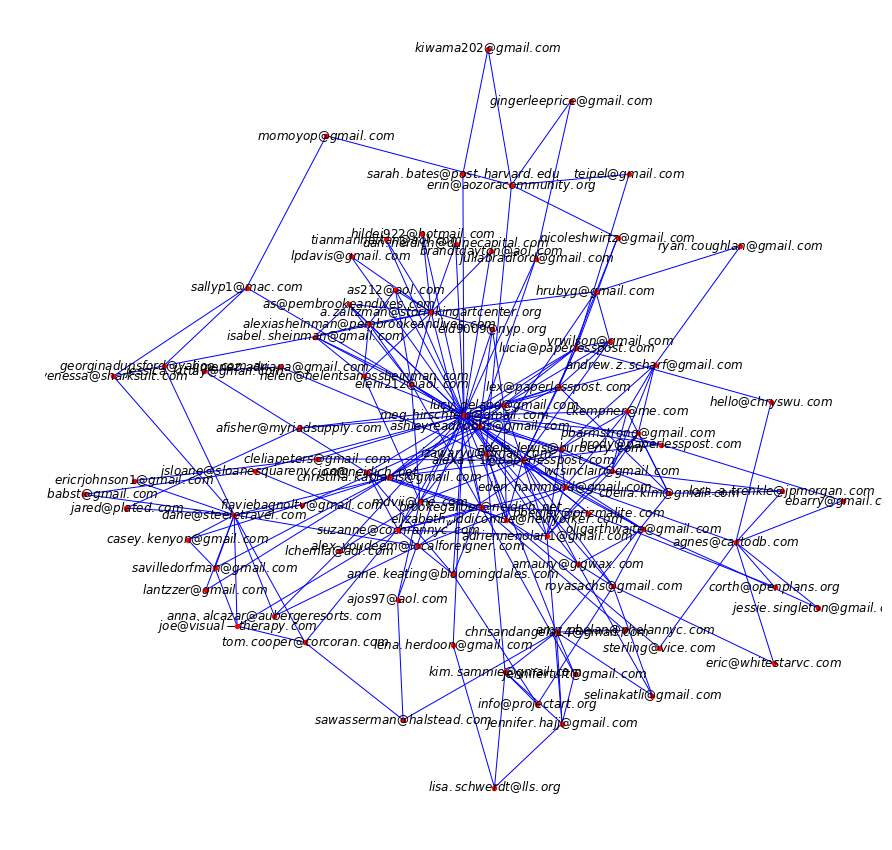

In [122]:
start_time = datetime.now()

str_query = query_paths(str_acct)
path_edges = execute_query(str_query)

G_paths = nx.from_pandas_edgelist(path_edges, 'a', 'b', ['bond'])

pos = nx.spring_layout(G_paths)
plt.figure(1,figsize=(15,15))
plt.subplot(111)
nx.draw(G_paths,pos,node_size=20,edge_color='b')

# Create the networkx diagram labels from the list of emails.
str_query = query_accounts(str_acct)
all_accounts = execute_query(str_query)
emails = all_accounts['email_address']

labels = {}
for idx,val in enumerate(all_accounts['id']):
    labels[val] = r'$'+emails[idx]+'$'
# Draw the labels
nx.draw_networkx_labels(G,pos,labels)

print('completed in: ' + str(datetime.now() - start_time))